### Описание проекта

Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

###  Откроем файл с данными и изучим общую информацию.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# Прочитаем файл с данными  и сохраним его в переменной data, посмотрим общую информацию о данных и выведем данные на экран.
data=pd.read_csv('/datasets/games.csv')
data.info() 
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Посмотрим статистические данные таблицы.
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [1]:
# Напишим функцию для нахождения пропусков и процентного соотношения пропусков ко всем данным
def search_for_passes(data):
    print("|{: <20}|".format("Столбец"),"{: <20}|".format("количество пропусков"),"{: <25}|".format("процент от общего числа"))
    print('-----------------------------------------------------------------------')
    for i in data.columns:
        if data[i].isna().sum() != 0:
            print("|{: <20}|".format(i),"{: ^20}|".format(data[i].isna().sum()),"{: ^25.1%}|".format(data[i].isna().sum()/data.shape[0]))

In [5]:
search_for_passes(data)

|Столбец             | количество пропусков| процентов от общего числа|
-----------------------------------------------------------------------
|Name                |          2          |           0.0%           |
|Year_of_Release     |         269         |           1.6%           |
|Genre               |          2          |           0.0%           |
|Critic_Score        |         8578        |           51.3%          |
|User_Score          |         6701        |           40.1%          |
|Rating              |         6766        |           40.5%          |


In [6]:
# Проверим на наличие дубликатов
data.duplicated().sum()

0

- Данные состоят из 16715 строк и 11 столбцов. 
- Изучив общую информацию мы обнаружили наличие пропусков в данных. Пропуски могут возникнуть в результате ошибки при выгрузке данных,при заполнении данных в таблицу, при объединении нескольких таблиц. 
- Имеются столбцы с некоррекными типами данных.
- Дубликатов нет

In [59]:
pd.concat([
    data.isna().sum().to_frame(name='Cnt nulls'),
    data.isna().mean().to_frame(name='Perc nulls')
], axis=1)\
    .sort_values(by='Cnt nulls')\
    .style.bar()

,Cnt nulls,Perc nulls
platform,0,0
na_sales,0,0
eu_sales,0,0
jp_sales,0,0
other_sales,0,0
rating,0,0
total_sales,0,0
name,2,0.000119653
genre,2,0.000119653
year_of_release,269,0.0160933


### Подготовка данных.

#### Заменим названия столбцов (приведем к нижнему регистру)

In [7]:
for i in data.columns:
    data = data.rename(columns={i: i.lower()}).reset_index(drop=True)

#### Преобразуем данные в нужные типы.

In [8]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце 'user_score' находится cтроковое значение, аббривеатура "tbd"-To Be Determined(Будет распределено). Используется, если информация еще не определена или решение по вопросу не принято. Заменим это значение на nan. А тип данных user_score на float64.

In [9]:
data['user_score']=pd.to_numeric(data['user_score'],errors='coerce')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [11]:
# тип данных year_of_release изменим на Int64.
data['year_of_release']=data['year_of_release'].astype('Int64')

#### Обработка пропусков

In [12]:
# Заменим пропуски в столбце Rating на 'nan'
data['rating']=data['rating'].fillna('nan')

#### Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [13]:
data['total_sales']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']  
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,nan,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,nan,31.38


При подготовке данных мы: 
-  привели названия столбцов к нижнему регистру
-  преобразовали данные в нужные типы, столкнулись с аббривеатурой "tbd"-To Be Determined(Будет распределено) и заменили её пропуском
- посчитали суммарные продажи во всех регионах и запишим их в отдельный столбец
- Заменили пропуски в столбце 'rating' на 'nan', для того чтобы учитывать их в исследовании как отдельную категорию. Остальные пропуски  заменять не будем ,т.к нет релевантных значений для замены. Удалять их также не будем, чтобы не потерять необходимые данные для исследования.


### Проведем исследовательский анализ данных.

#### Посмотрим, сколько игр выпускалось в разные годы.

<Figure size 576x288 with 0 Axes>

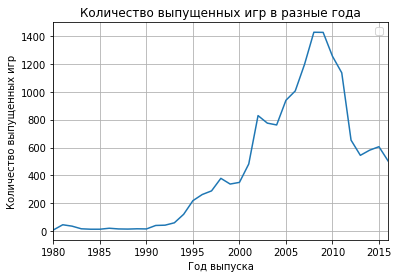

In [14]:
amount_games=data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(8,4))
amount_games.plot(grid = True)
plt.title("Количество выпущенных игр в разные года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')
plt.show()

- бурный рост количества выпущенных игр приходится на 1990 год, что связано с активным развитем в эти года компьютерной техники и увеличением количества персональных компьютеров и консолей. Данные раньше 1990 года не имеют сильной важности.
- существенное падение количества выпускаемых игр вероятнее всего связано с развитием в 2008 году смартфонов, и увеличением количества мобильных игр

#### Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим за какой характерный срок появляются новые и исчезают старые платформы

Text(0, 0.5, 'Количество продаж')

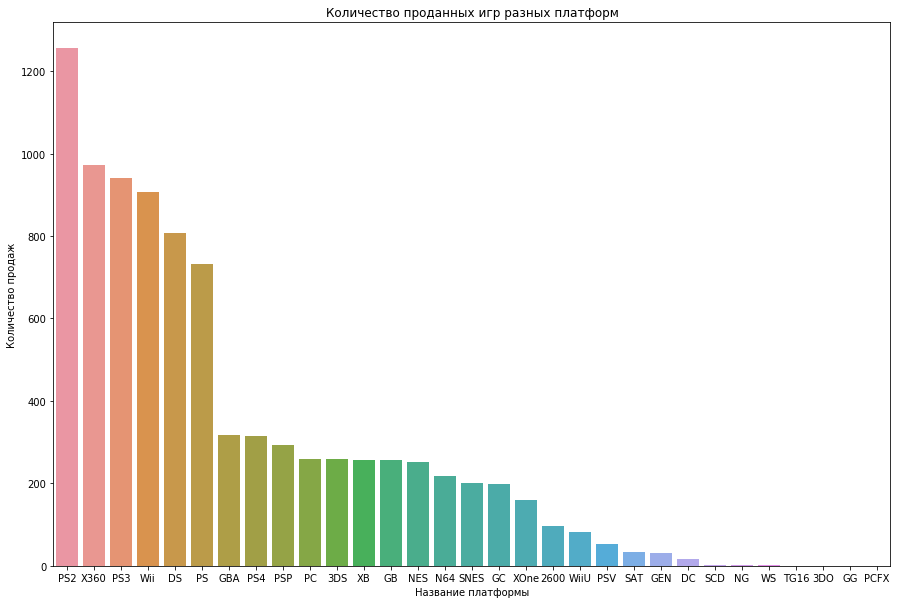

In [15]:
# Посмотрим на распределение количества проданных игр
data_platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales'
                                                                                                          ,ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=data_platform_sales.index,y=data_platform_sales['total_sales'])
plt.title("Количество проданных игр разных платформ")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Мы видим,что по количествам продаж выделяются 6 платформ. Бесспорным лидером является playstation 2

In [16]:
# выделим топ 6 самых продаваемых платформ
top_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(6)
top_platform = top_platform.reset_index()
top_platform

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86


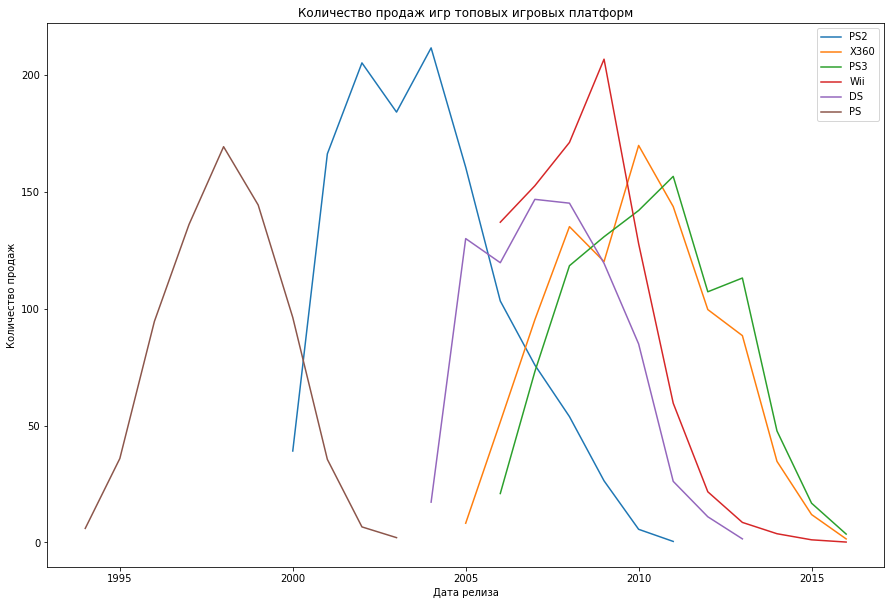

In [17]:
# Напишим функцию для подсчета количества выпущенных игр в зависимости от года
def year_platform_total_sale(name, data):
    data_platform = data[(data['platform'] == name) & (data['year_of_release'] > 1990)]
    total_sale = data_platform.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').sort_values('year_of_release', ascending=False).reset_index()
    return total_sale
# Выведем количество выпущенных игр топ платформ
plt.figure(figsize=(15,10))
for i in top_platform['platform']:
    sns.lineplot(data=year_platform_total_sale(i,data),x='year_of_release',y='total_sales', label=i)
    plt.legend()
    plt.title('Количество продаж игр топовых игровых платформ')
    plt.xlabel('Дата релиза')
    plt.ylabel('Количество продаж')  

Мы видим, что характерный срок жизни платформы около 10 лет. Первые 5 лет идет рост количества продаж, следующие 5 лет идет снижение продаж. Значит актуальным периодом для 2017 года будет пятилетний период с 2011 по 2016 год. 

#### Выберем платформы лидирующие по продажам в актуальный период, определим растут или падают продажи? Выберем несколько потенциально прибыльных платформ

In [18]:
#Выберем данные актульного периода
data_actualy_period=data.query('year_of_release >= 2011')

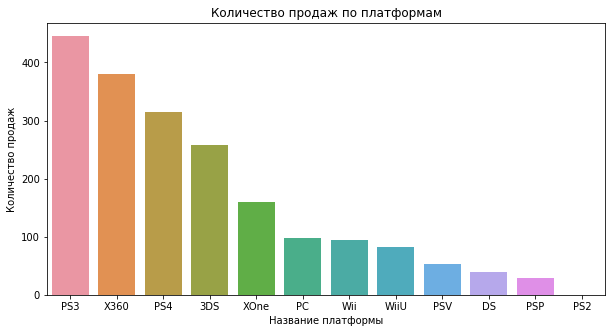

In [19]:
# Посмотрим на распределение количества проданных игр
data_platform_sales_ap = data_actualy_period.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales'
                                                                                                          ,ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=data_platform_sales_ap.index,y=data_platform_sales_ap['total_sales'])
plt.title("Количество продаж по платформам")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

In [20]:
# Выберем топ 5 популярных платформ
top_platform_ap = data_actualy_period.pivot_table(index='platform',values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(5)
top_platform_ap = top_platform_ap.reset_index()
top_platform_ap

,platform,total_sales
0,PS3,445.57
1,X360,380.38
2,PS4,314.14
3,3DS,257.81
4,XOne,159.32


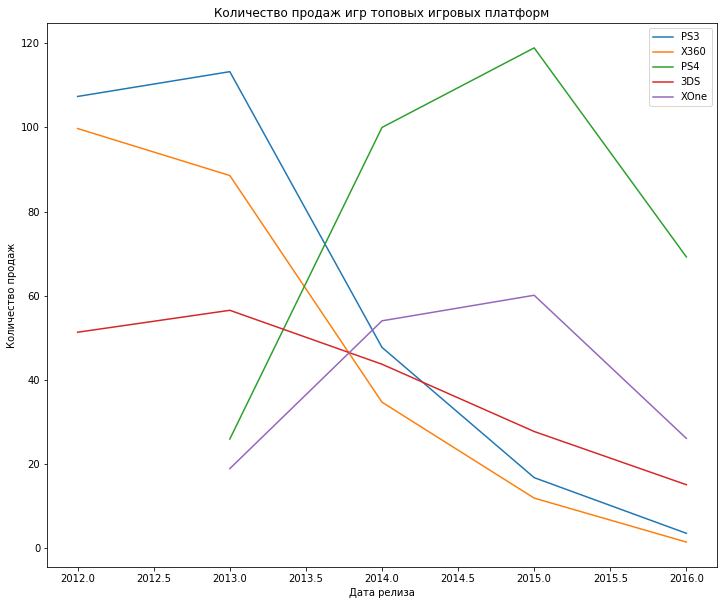

In [21]:
#Напишим функцию для подсчета количества выпущенных игр в актуальный период
def year_platform_total_sale_ap(name, data):
    data_platform = data[(data['platform'] == name) & (data['year_of_release'] > 2011)]
    total_sale = data_platform.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').sort_values('year_of_release', ascending=False).reset_index()
    return total_sale
# Выведем количество выпущенных игр топ платформ актуального периода
plt.figure(figsize=(12,10))
for i in top_platform_ap['platform']:
    sns.lineplot(data=year_platform_total_sale_ap(i,data),x='year_of_release',y='total_sales', label=i)
    plt.legend()
    plt.title('Количество продаж игр топовых игровых платформ')
    plt.xlabel('Дата релиза')
    plt.ylabel('Количество продаж')  

Самыми популярными платформами актульного периода, являются Playstation 3 и Xbox360. Потенциально прибыльными платформами являются следующие поколения Xbox и Playstation, так как на 2016 год платформы этих призводителей(XOne, PS4) так же являются лидерами по количеству продаж. Продажи топ платформ снижаются так как находятся во второй пятилетке своего жизненного цикла. 

#### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам


In [22]:
data_top_platform_ap = data[data['platform'].isin(top_platform_ap['platform'])]

In [23]:
desc_stat = data_top_platform_ap.pivot_table(index=['platform'], values=['total_sales'], 
                    aggfunc={'total_sales': [np.mean, np.var, np.std]}
                             )
                             
desc_stat

total_sales                    
                mean       std       var
platform                                
3DS         0.498077  1.430876  2.047406
PS3         0.705973  1.391749  1.936966
PS4         0.801378  1.609456  2.590350
X360        0.769746  1.615674  2.610403
XOne        0.645020  1.036139  1.073584

Text(0, 0.5, 'Глобальные продажи')

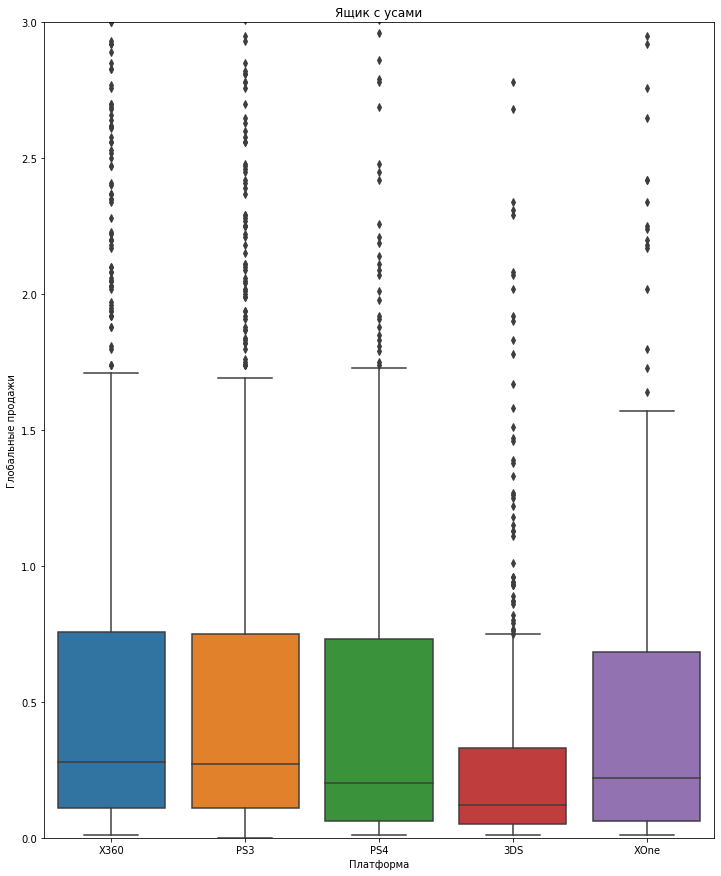

In [24]:
#Отрисуем ящики с усами 
plt.figure(figsize=(12,15))
plt.ylim(0, 3)
sns.boxplot(data=data_top_platform_ap, x='platform', y='total_sales')
plt.title('Ящик с усами')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
    #sns.catplot(x="platform", y='total_sales', kind="box", data=data_platform, orient='v')

- Провели срез данных для того, чтобы отрисовать ящики с усами. 
- Исходя из графиков видно, что медиана протекает у X360 и PS3 практически одинаково, так же и у XOne и PS4
- Больше всех продаж у PS3, затем X360, после PS4, XOne и 3DS на последнем месте. 

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами популярных платформ . 

In [25]:
#Корреляция между оценками пользователей и продажами PS3
data_ps3 = data_top_platform_ap[data_top_platform_ap['platform']=='PS3']
data_ps3['user_score'].corr(data_ps3['total_sales'])

0.12669133936341712

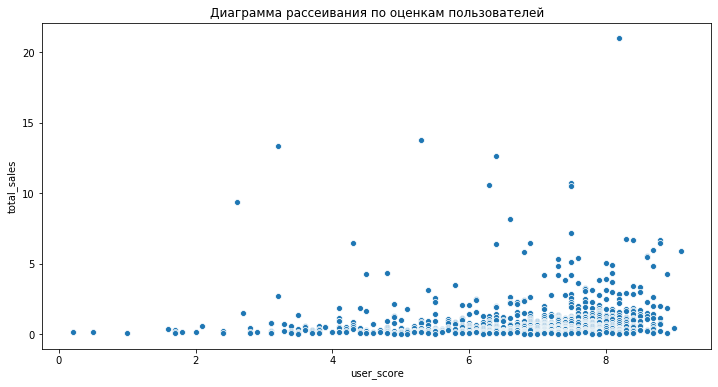

In [26]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=data_ps3)
plt.title('Диаграмма рассеивания по оценкам пользователей')
plt.show()

In [27]:
#Корреляция между оценками критиков и продажами PS3
data_ps3['critic_score'].corr(data_ps3['total_sales'])

0.4324315685642061

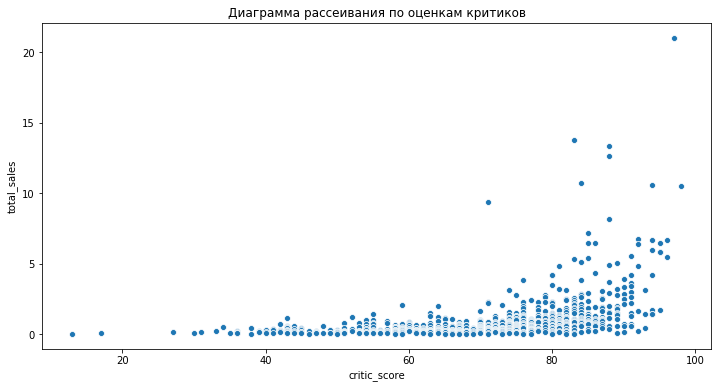

In [28]:
#Построим диаграмму рассеяния по оценкам критиков 
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=data_ps3)
plt.title('Диаграмма рассеивания по оценкам критиков')
plt.show()

Судя по диаграммам размаха и корреляцией между оценками и продажами можно сделать вывод, что оценка критиков влияет на продажи значительней оценок пользователей.Покупатели прислушиваются больше к критикам чем к оценкам других пользователей.

корреляция отзывов пользователей, платформа  X360 0.11445882978454186
корреляция отзывов критиков, платформа  X360 0.3937358653072588


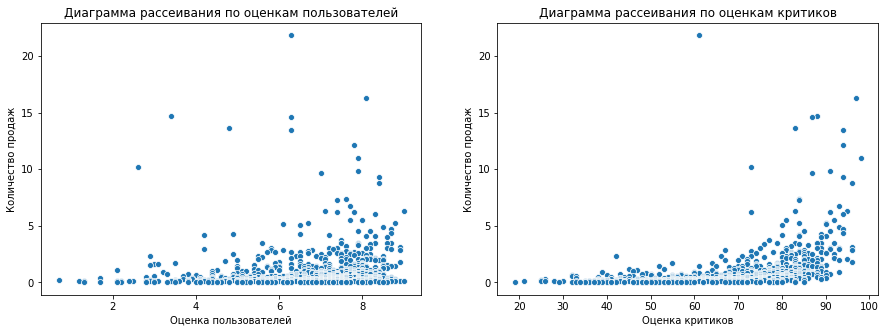

корреляция отзывов пользователей, платформа  PS4 -0.031957110204556424
корреляция отзывов критиков, платформа  PS4 0.406567902061781


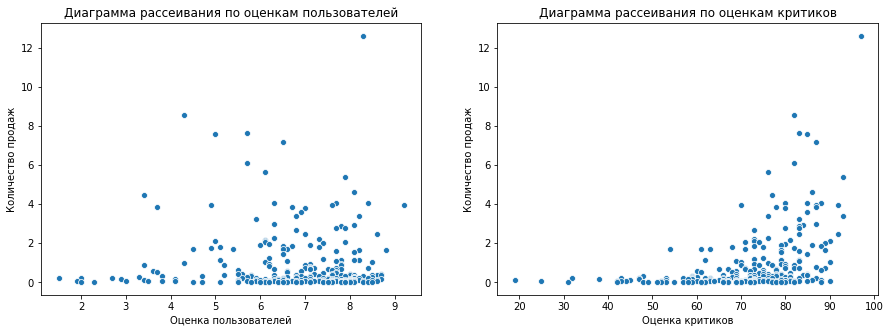

корреляция отзывов пользователей, платформа  XOne -0.06892505328279412
корреляция отзывов критиков, платформа  XOne 0.41699832800840175


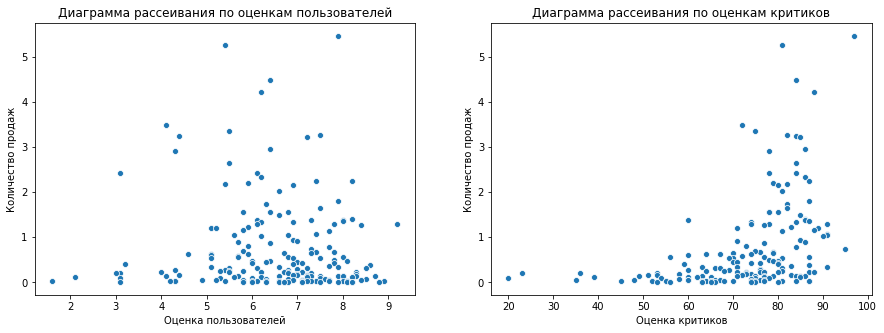

корреляция отзывов пользователей, платформа  3DS 0.22480798039571082
корреляция отзывов критиков, платформа  3DS 0.3494009303924131


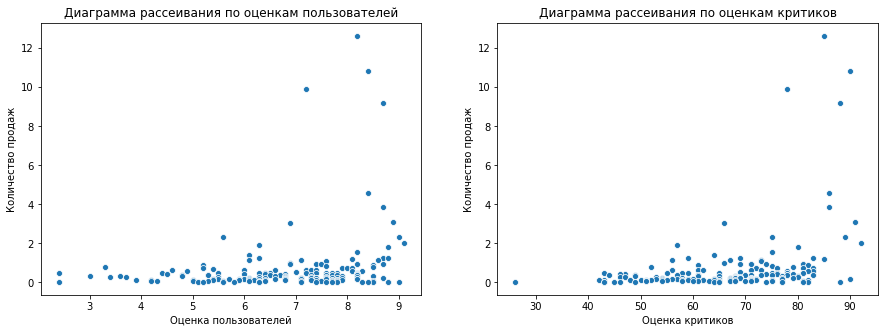

In [29]:
list_of_top = ['X360','PS4','XOne','3DS']
for platform in list_of_top:
    new_data=data.query('platform == @platform')
    print('корреляция отзывов пользователей, платформа ',platform,new_data['total_sales'].corr(new_data['user_score']))
    print('корреляция отзывов критиков, платформа ',platform,new_data['total_sales'].corr(new_data['critic_score']))
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=new_data, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=new_data, ax=ax[1])
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    ax[0].set(title='Диаграмма рассеивания по оценкам пользователей')
    ax[1].set(title='Диаграмма рассеивания по оценкам критиков')
    plt.show()

Сравнив корреляцию и построив диаграммы размаха для других платформ видим,что зависимость сохраняется и покупатели также прислушиваются больше к критикам чем к оценкам других пользователей.

#### Посмотрим на общее распределение игр по жанрам. 

In [30]:
distr_genre = data.pivot_table(
    index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
distr_genre = distr_genre.reset_index()
distr_genre

,genre,total_sales
0,Action,1744.17
1,Sports,1331.27
2,Shooter,1052.45
3,Role-Playing,934.56
4,Platform,827.77
5,Misc,802.51
6,Racing,728.67
7,Fighting,447.53
8,Simulation,389.97
9,Puzzle,242.57


Text(0.5, 1.0, 'Суммарный объём продаж по игровым жанрам')

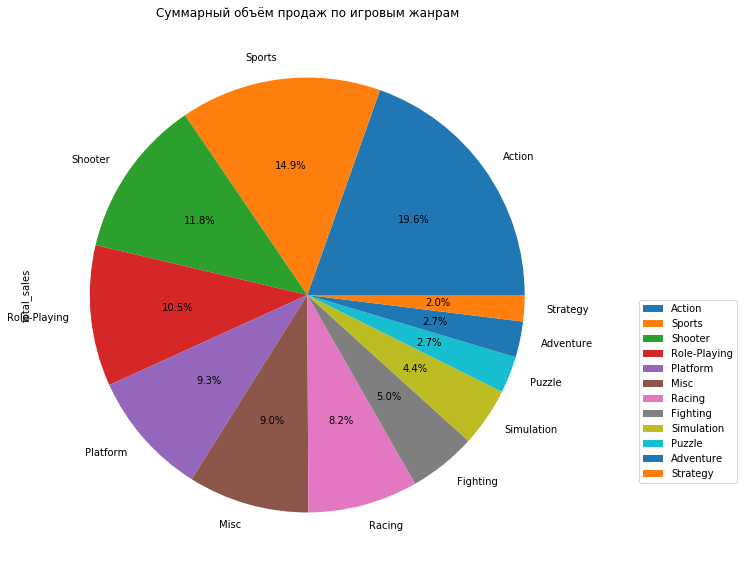

In [31]:
# Построим круговую диграмму распределения игр по жанрам
(data.pivot_table(index="genre", values="total_sales", aggfunc="sum")
.sort_values('total_sales', ascending = False)
.plot(y="total_sales", kind="pie", figsize=(10, 10), autopct='%1.1f%%'))

plt.legend(bbox_to_anchor=(0.7, 0, 0.6, 0.5)) # Расположение легенды на графике
plt.title('Суммарный объём продаж по игровым жанрам') 

Наиболее популярными являются Action и Sport игры, самые непопулярные-это Strategy и Adventure.

### Составим портрет пользователя каждого региона

In [32]:
# Напишим функцию для подсчета топ 5 

def pasport_user(region,category):
    top = (data_actualy_period.pivot_table(index=category,values=region, aggfunc = 'sum')
         .sort_values(by=region,ascending=False).head())
    return top

# Функция для построения круговой диаграммы распределения рынка
def pasport_pie(region,category):
    
    return (
    data_actualy_period
    .pivot_table(index=category, values=region, aggfunc="sum")
    .sort_values(region, ascending=False)
    .head()
    .plot(y=region, kind="pie", figsize=(8, 8),title='Распределение рынка', autopct='%1.1f%%')
    )
    plt.show()
   

####  Анализ пользователей региона NA

In [33]:
# Выберем самые популярные платформы 
pasport_user('na_sales','platform')

,na_sales
platform,
X360,226.80
PS3,168.26
PS4,108.74
XOne,93.12
3DS,82.65


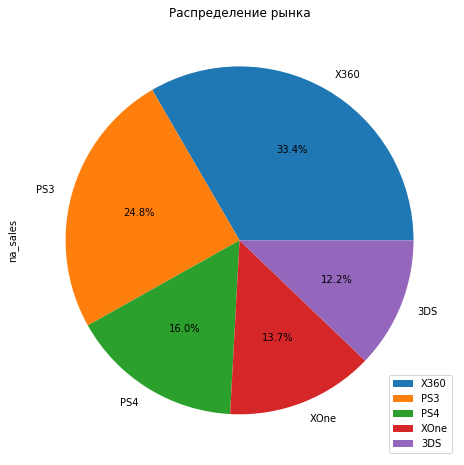

In [34]:
# построим круговую диаграмму распределения рынка
pasport_pie('na_sales','platform')

Самые популярные платформы в Северной Америке X360	и PS3	

In [35]:
# Выберем самые популярные жанры 
pasport_user('na_sales','genre')

,na_sales
genre,
Action,230.92
Shooter,194.43
Sports,108.70
Role-Playing,83.78
Misc,69.69


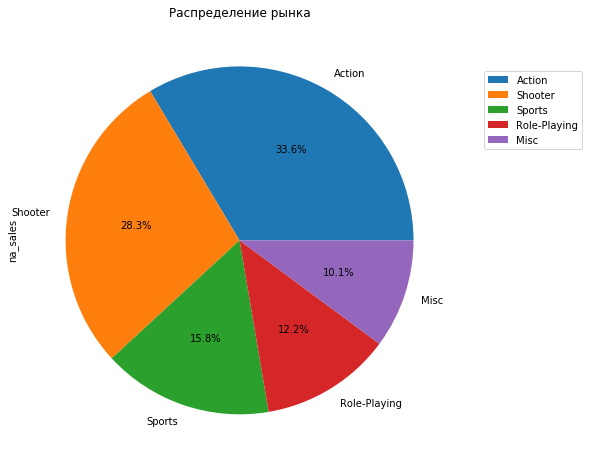

In [36]:
# построим круговую диаграмму распределения рынка
pasport_pie('na_sales','genre')
plt.legend(bbox_to_anchor=(0.7, 0, 0.6, 0.9))

Самые популярные игры в Северной Америке - это игры жанра Action и Shooter

In [37]:
# Влияние рейтинга на объем продаж
pasport_user('na_sales','rating')

,na_sales
rating,
M,308.45
E,170.17
nan,123.69
E10+,117.72
T,109.31


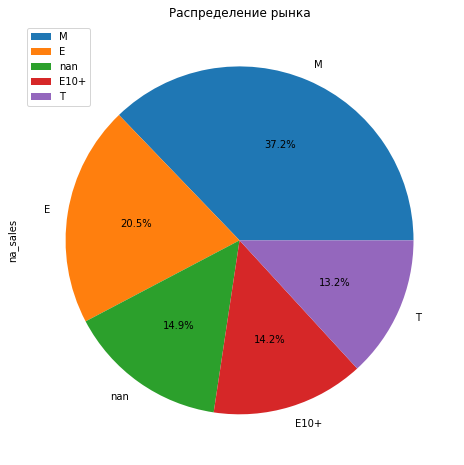

In [38]:
# построим круговую диаграмму распределения рынка
pasport_pie('na_sales','rating')

Визуально проанализировав полученные на круговой диаграмме результаты, можно сделать вывод, что оценка рейтинга ESRB влияет на объём продаж игр в данном регионе, таким образом игры с оценкой "M" составили наибольший суммарный объём продаж в данном регионе, а игры с рейтингом "T" и "E10+" имеют самую маленькую долю продаж в регионе.

#### Анализ пользователей региона EU

In [39]:
# Выберем самые популярные платформы 
pasport_user('eu_sales','platform')

,eu_sales
platform,
PS3,163.10
PS4,141.09
X360,117.10
3DS,61.27
PC,56.70


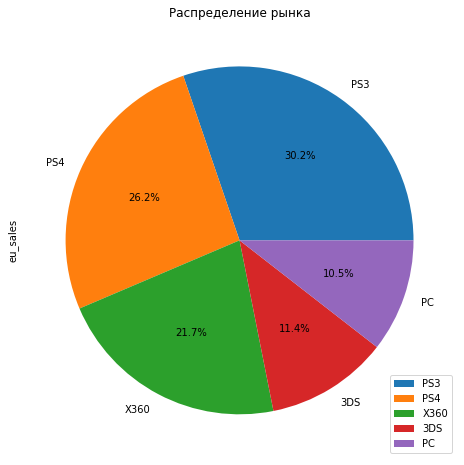

In [40]:
# построим круговую диаграмму распределения рынка
pasport_pie('eu_sales','platform')

Самые популярные платформы в Европе PS3	и PS4	

In [41]:
# Выберем самые популярные жанры 
pasport_user('eu_sales','genre')

,eu_sales
genre,
Action,199.12
Shooter,148.02
Sports,88.48
Role-Playing,62.30
Racing,40.58


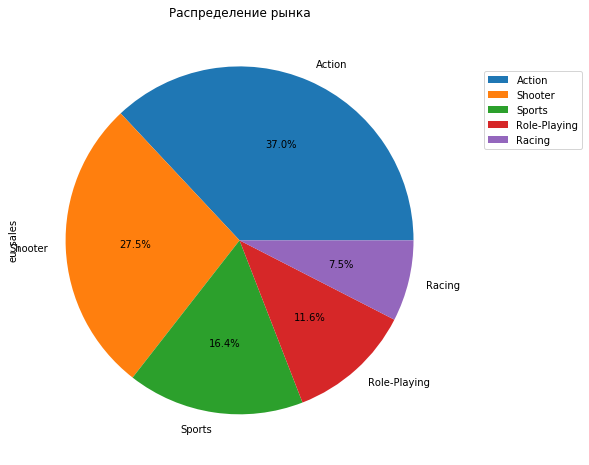

In [42]:
# построим круговую диаграмму распределения рынка
pasport_pie('eu_sales','genre')
plt.legend(bbox_to_anchor=(0.7, 0, 0.6, 0.9))

Самые популярные игры в Европе - это игры жанра Action и Shooter

In [43]:
# Влияние рейтинга на объем продаж
pasport_user('eu_sales','rating')

,eu_sales
rating,
M,250.26
E,141.73
nan,116.61
T,83.16
E10+,78.00


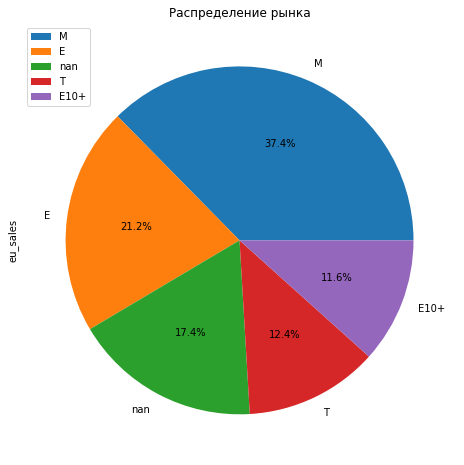

In [44]:
# построим круговую диаграмму распределения рынка
pasport_pie('eu_sales','rating')

Визуально проанализировав полученные на круговой диаграмме результаты, можно сделать вывод, что оценка рейтинга ESRB влияет на объём продаж игр в данном регионе, таким образом игры с оценкой "M" составили наибольший суммарный объём продаж в данном регионе, а игры с рейтингом "T" и "E10+" имеют самую маленькую долю продаж в регионе.

#### Анализ пользователей региона JP

In [45]:
# Выберем самые популярные платформы 
pasport_user('jp_sales','platform')

,jp_sales
platform,
3DS,100.62
PS3,49.39
PSP,24.04
PSV,21.84
PS4,15.96


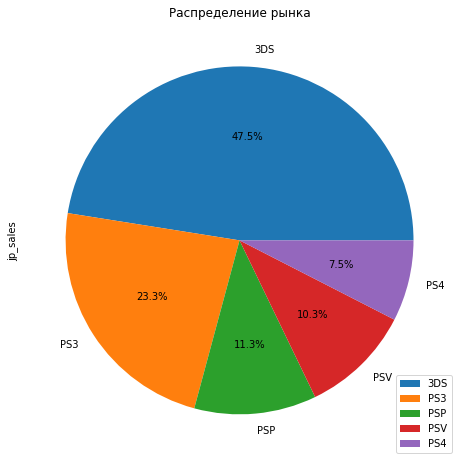

In [46]:
# построим круговую диаграмму распределения рынка
pasport_pie('jp_sales','platform')

Самые популярные платформы в Японии 3DS и PS4

In [47]:
pasport_user('jp_sales','genre')

,jp_sales
genre,
Role-Playing,79.87
Action,63.62
Misc,17.60
Fighting,12.38
Platform,12.13


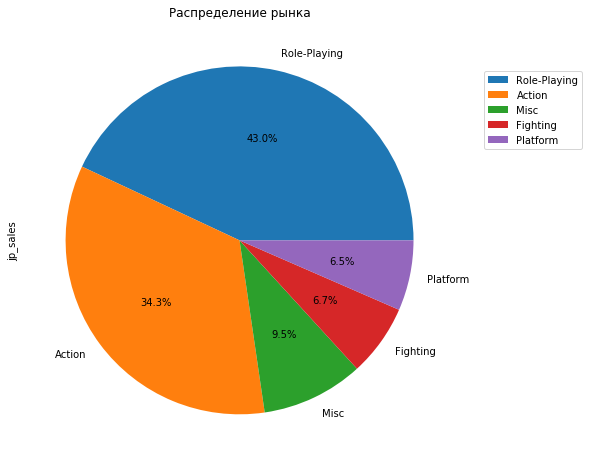

In [48]:
# построим круговую диаграмму распределения рынка
pasport_pie('jp_sales','genre')
plt.legend(bbox_to_anchor=(0.7, 0, 0.6, 0.9))

Самые популярные игры в Японии - это игры жанра Role-Playing и Action

In [49]:
# Влияние рейтинга на объем продаж
pasport_user('jp_sales','rating')

,jp_sales
rating,
nan,138.21
E,36.68
T,33.39
M,26.14
E10+,11.23


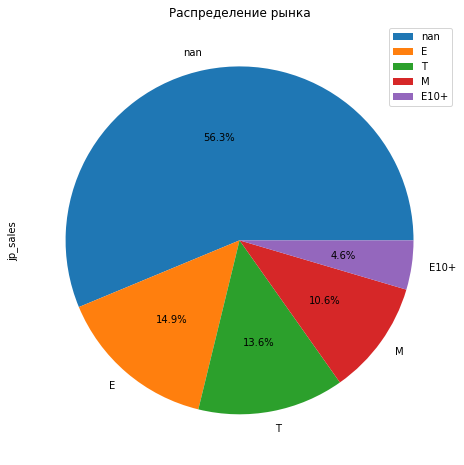

In [50]:
# построим круговую диаграмму распределения рынка
pasport_pie('jp_sales','rating')

Для Японского рынка ситуация отличается от NA и EU рынков,т.к мы видим что большую долю 56,3% занимают игры с неопределенным рейтингом, поэтому мы точно не можем утверждать о влиянии рейтинга ESRB на объём продаж игр в данном регионе. Можно предположить что в Яониии большое количество игр без рейтинга потому что ESRB принимает и определяет рейтинги для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде, а в Японии большое количество игр для внутреннего потребления.

Проанализировав паспорта пользователей разных регионов можно сделать вывод, что пользователи в Северной Америке и Европе приблизительно похожи друг на друга, играют больше в игры Action и Shooter жанров. В Северной Америке больше предпочитают Xbox, а в Европе Playstation, но общее распределение предпочтений схоже. Пользователи из Японии значительно отличаются от других, больше всего предпочитают 3DS платформу и играют чаще в игры жанра Role-Playing и Action. Также мы увидили, что большая часть игр в Японии без рейтинга ESRB.

In [68]:
pd.concat([pasport_user(s, 'platform')\
               .reset_index().rename(columns={'platform': s[:2]}) for s in ['na_sales', 'eu_sales', 'jp_sales']], axis=1)\
    .style.bar(color='#91E9FF')

,na,na_sales,eu,eu_sales,jp,jp_sales
0,X360,226.8,PS3,163.1,3DS,100.62
1,PS3,168.26,PS4,141.09,PS3,49.39
2,PS4,108.74,X360,117.1,PSP,24.04
3,XOne,93.12,3DS,61.27,PSV,21.84
4,3DS,82.65,PC,56.7,PS4,15.96


### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [51]:
# выделим данные с  платформами PC и XOne
data_XOne_PC=data_actualy_period.query('platform == "XOne" | platform == "PC"')
# посчитаем для них среднее значение, дисперсию и стандартное отклонение оценок пользователей.
desc_stat = data_XOne_PC.pivot_table(index=['platform'], values=['user_score'], 
                    aggfunc={'user_score': [np.mean, np.var, np.std]})
desc_stat

user_score                    
               mean       std       var
platform                               
PC         6.451792  1.611303  2.596296
XOne       6.521429  1.380941  1.906997

In [52]:
# выделим данные для каждой платформы
data_XOne=data_actualy_period.query('platform == "XOne"')
data_PC=data_actualy_period.query('platform == "PC"')

Проверим гипотезу, используя встроенную в библиотеку scipy функцию ttest_ind - которая вычисляет уровень значимости критерия Стьюдента для двух независимых выборок. Зададим степень свободы 1, т.к. работаем с выборками из генеральной совокупности.

In [53]:
sample_1=data_XOne['user_score'].dropna()
sample_2=data_PC['user_score'].dropna()
alpha = 0.01
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.6267602271422398
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что мы отвергаем гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC в актуальный период времени, значит принимаем альтернативную гипотезу предпологаем, .

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза - средние пользовательские рейтинги жанров Action и Sports разные.

In [54]:
# выделим данные с жанрами Action и Sports
data_Action_Sports=data_actualy_period.query('genre == "Action" | genre == "Sports"')
# посчитаем для них среднее значение, дисперсию и стандартное отклонение оценок пользователей.
desc_stat = data_Action_Sports.pivot_table(index=['genre'], values=['user_score'], 
                    aggfunc={'user_score': [np.mean, np.var, np.std]})
desc_stat

user_score                    
             mean       std       var
genre                                
Action   6.775904  1.346060  1.811877
Sports   5.650813  1.697795  2.882510

In [55]:
# выделим данные для каждго жанра
data_action=data_actualy_period.query('genre == "Action"')
data_sports=data_actualy_period.query('genre == "Sports"')

Аналогично предыдущему примеру вычислим уровень значимости.

In [56]:
sample_1=data_action['user_score'].dropna()
sample_2=data_sports['user_score'].dropna()
alpha = 0.01
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue > alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.1974550252152054e-24
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value не дает возможности отвергать исходную гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые. 

### Общий вывод

- Целью данного исследования было выявление определяющих успешность игры закономерностей.
- Входные данные — данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).
- В процессе предобработки данных мы заменили названия столбцов, преобразовали данные в нужные типы, заполнили пропуски 
в столбце 'rating'  на 'nan', для того чтобы учитывать их в исследовании как отдельную категорию.
- Посчитали суммарные продажи во всех регионах и записали их в отдельный столбец.
- При анализе данных посчитали сколько игр выпускалось в разные годы, посмотрите, как менялись продажи по платформам. 
- Выбрали платформы с наибольшими суммарными продажами,лидер по продажам PS2.
- Определили, что характерный срок появления новых и исчезания старых платформ равен 10 годам, из этого определили актуальный период равный 5 годам.
- Определили какие платформы лидируют по продажам. Выбрали несколько потенциально прибыльных платформ(Xbox и PS).
- Определили влияние на объем продаж рейтингов пользователей и критиков, пришли к выводу, что покупатели больше прислушиваются к рейтингу критиков.
- Составили портреты пользователей Северной Америки, Европы и Японии и увидели,что предпочтения пользователей Америки и Европы схожи, а предпочтения пользователей Японии отличаются от них. Также мы увидили, что большая часть игр в Японии без рейтинга ESRB.
- Проверили гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые и отвергли её.
- Проверили гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные и также отвергли её.
- Для проверки гипотез мы использовали уровень значимости критерия Стьюдента для независимых выборок, т.к. средние значения выборок не зависят друг от друга.
- Проведя анализ данных пможно прийти к выводу, что наиболее перспективными являются игры для платформ Xbox и PS, жанра Action и с рейтингом ESRB "M"(для взрослых от 17лет).
- Также наблюдаем тенденцию к снижению общего объема продаж в последние годы, начиная с 2008г, что скорее всего связано с развитием индустрии мобильных игр.
